In [1]:
%load_ext autoreload
%autoreload 2
!pip install plotly

In [2]:
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import joblib

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Load dữ liệu từ csv (đường dẫn thay bằng file thực tế)
data = pd.read_csv('/content/drive/MyDrive/HocMay_FinalExam/2000-2018.csv')


In [5]:
# 2. Xử lý runtime và year như numeric (nếu dữ liệu sạch)
data['runtime'] = pd.to_numeric(data['runtime'], errors='coerce')
data['year'] = pd.to_numeric(data['year'], errors='coerce')


# Xóa dòng có giá trị NaN sau chuyển đổi
data = data.dropna(subset=['runtime', 'year', 'avgRating'])

In [6]:
data[["genre_1","genre_2","genre_3"]] = data['genre'].str.split(',', n = 3, expand=True)
data = data.drop(['genre'], axis=1)

In [12]:
data.head()

,title,year,avgRating,votes,directorName,writeName,runtime,genre_1,genre_2,genre_3
0,Isle of Dogs,2018,8.2,18140,Wes Anderson,Roman Coppola,101,Adventure,Animation,Comedy
1,Isle of Dogs,2018,8.2,18140,Wes Anderson,Kunichi Nomura,101,Adventure,Animation,Comedy
2,Isle of Dogs,2018,8.2,18140,Wes Anderson,Wes Anderson,101,Adventure,Animation,Comedy
3,Isle of Dogs,2018,8.2,18140,Wes Anderson,Jason Schwartzman,101,Adventure,Animation,Comedy
4,A Quiet Place,2018,8.1,68050,John Krasinski,Bryan Woods,90,Drama,Horror,Sci-Fi


In [7]:
data['genre_1'] = data['genre_1'].str.replace(' ', '')
data['genre_2'] = data['genre_2'].str.replace(' ', '')
data['genre_3'] = data['genre_3'].str.replace(' ', '')


In [8]:
# Lấy danh sách thể loại duy nhất
l1 = data.genre_1.unique()
l2 = data.genre_2.unique()
l3 = data.genre_3.unique()
all_genres = list(l1) + list(l2) + list(l3)
all_genres = [g for g in all_genres if pd.notna(g) and g != '']
all_genres = list(set(all_genres))


In [9]:
len(all_genres)

22

In [10]:
# Tạo cột one-hot cho từng thể loại, khởi tạo bằng 0
for genre in all_genres:
    data[genre] = 0

# Gán giá trị 1 nếu thể loại có trong 1 trong 3 cột genre_1,2,3
for idx, row in data.iterrows():
    for genre in all_genres:
        if (row['genre_1'] == genre) or (row['genre_2'] == genre) or (row['genre_3'] == genre):
            data.at[idx, genre] = 1

In [18]:
data.head()

,title,year,avgRating,votes,directorName,writeName,runtime,genre_1,genre_2,genre_3,...,Animation,Biography,Western,Drama,News,Adventure,Fantasy,Sci-Fi,Documentary,Action
0,Isle of Dogs,2018,8.2,18140,Wes Anderson,Roman Coppola,101,Adventure,Animation,Comedy,...,1,0,0,0,0,1,0,0,0,0
1,Isle of Dogs,2018,8.2,18140,Wes Anderson,Kunichi Nomura,101,Adventure,Animation,Comedy,...,1,0,0,0,0,1,0,0,0,0
2,Isle of Dogs,2018,8.2,18140,Wes Anderson,Wes Anderson,101,Adventure,Animation,Comedy,...,1,0,0,0,0,1,0,0,0,0
3,Isle of Dogs,2018,8.2,18140,Wes Anderson,Jason Schwartzman,101,Adventure,Animation,Comedy,...,1,0,0,0,0,1,0,0,0,0
4,A Quiet Place,2018,8.1,68050,John Krasinski,Bryan Woods,90,Drama,Horror,Sci-Fi,...,0,0,0,1,0,0,0,1,0,0


(np.float64(22.0), np.float64(0.0))

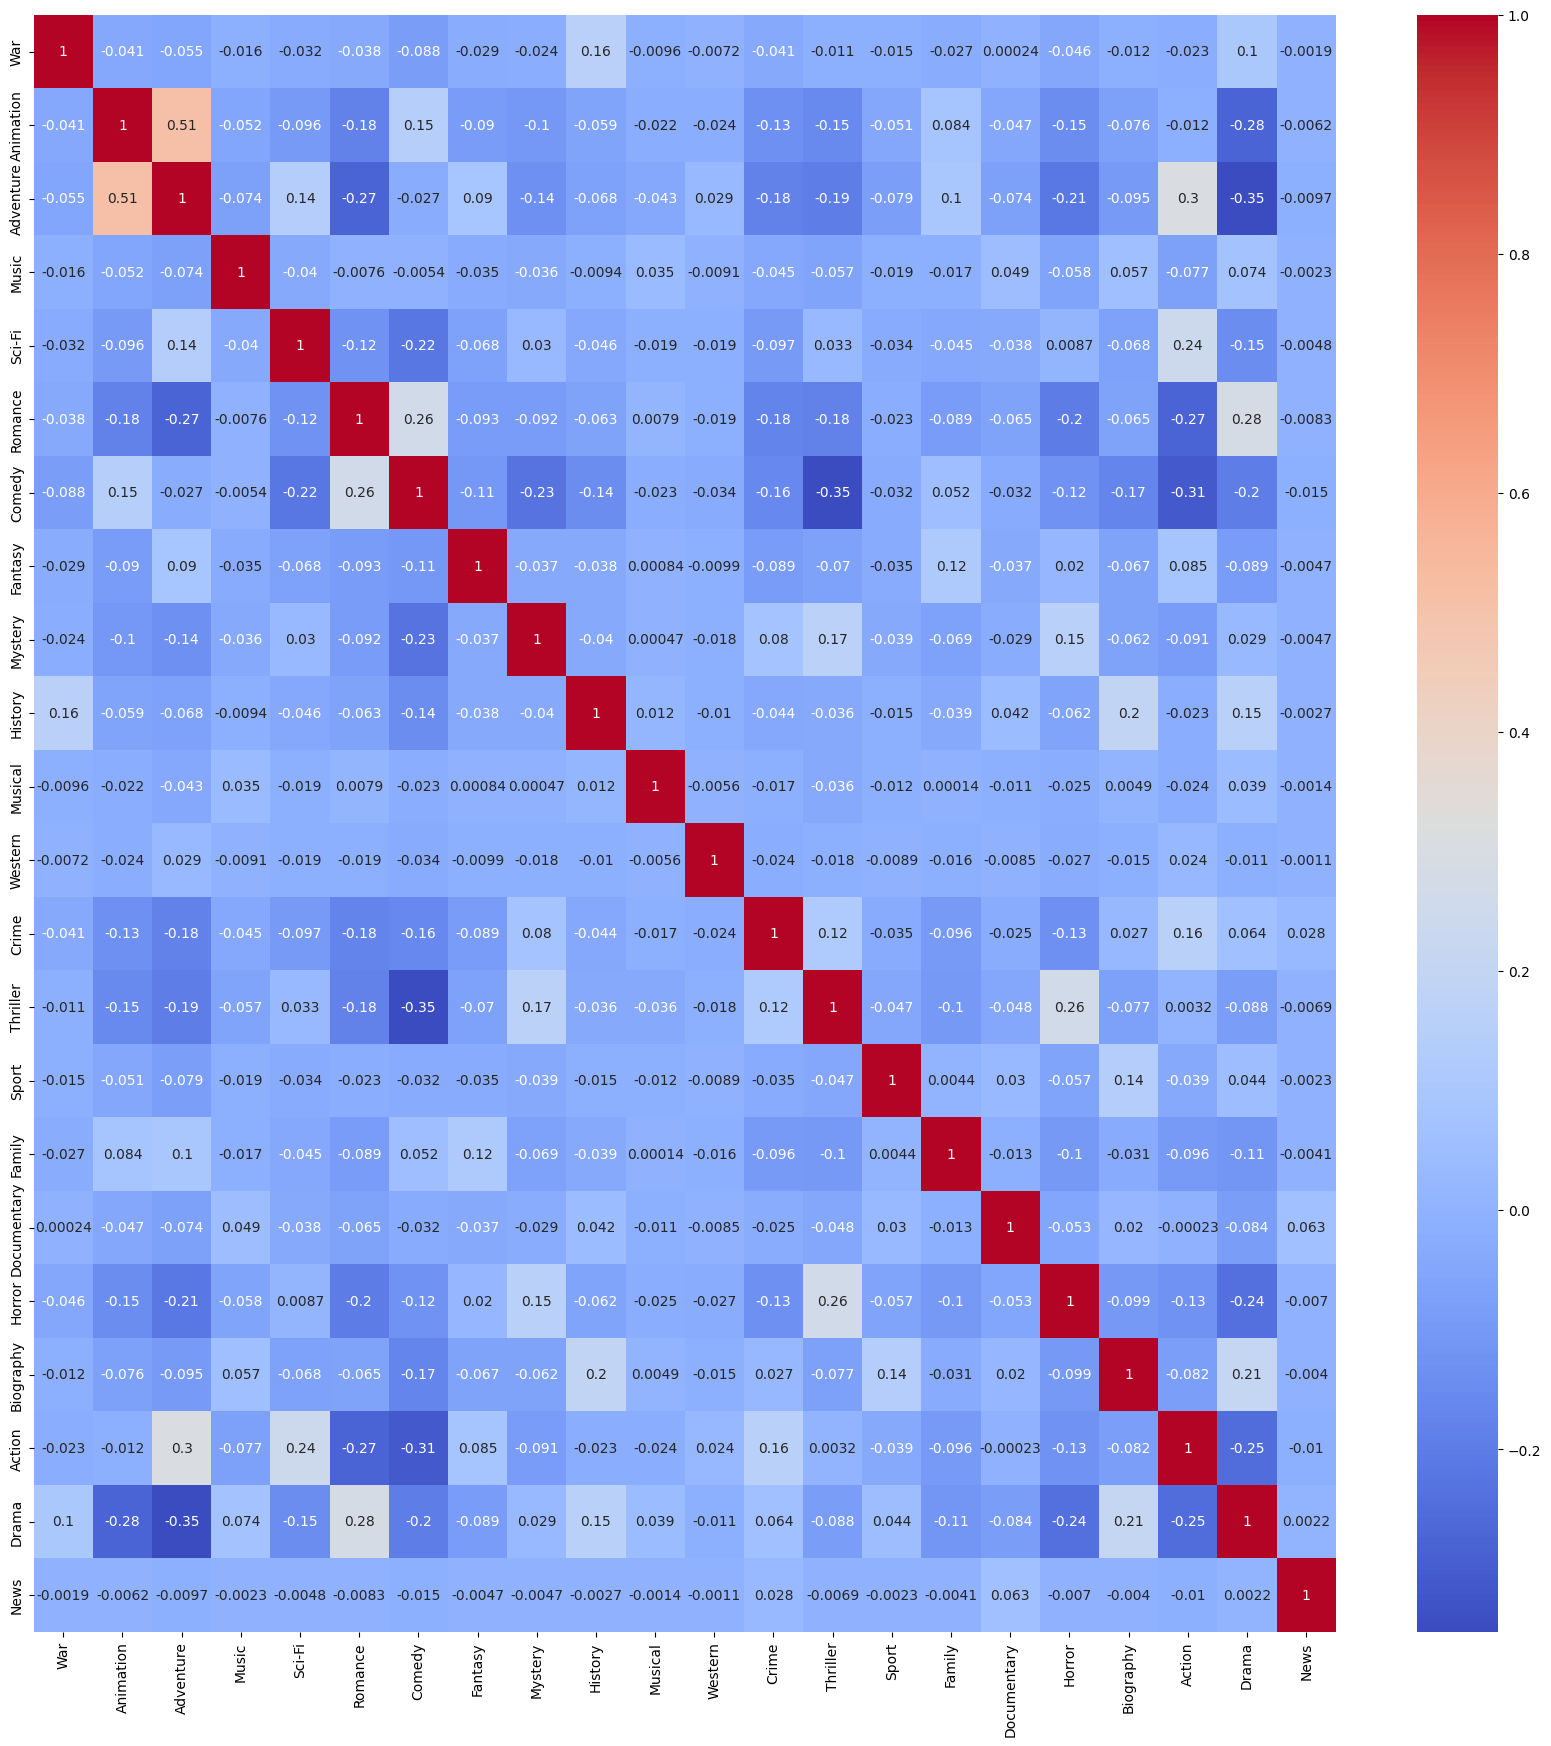

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(21,21))
# Changed 'l' to 'all_genres' to use the list of genre columns
cor = data[all_genres].corr()
sns.heatmap(cor, annot=True, cmap='coolwarm')
plt.ylim()

In [12]:
# Chuẩn bị dữ liệu cho model
categorical_columns = ['directorName', 'writeName']
numerical_columns = ['runtime', 'year']
genre_columns = all_genres

X = data[categorical_columns + numerical_columns + genre_columns]
y = data['avgRating']

In [13]:
# Pipeline tiền xử lý
from sklearn.preprocessing import StandardScaler # Import StandardScaler

categorical_pipeline = OneHotEncoder(handle_unknown='ignore') # Removed sparse=False
numerical_pipeline = StandardScaler()

preprocessor = ColumnTransformer(transformers=[
    ('cat', categorical_pipeline, categorical_columns),
    ('num', numerical_pipeline, numerical_columns),
    ('genre', 'passthrough', genre_columns)  # genre đã one-hot rồi
])

In [14]:
# Chia dữ liệu train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [26]:
# Pipeline mô hình với RandomForest
model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

# GridSearch để tìm tham số tốt nhất
param_grid = {
    'regressor__n_estimators': [100, 200],
    'regressor__max_depth': [10, 20, None],
    'regressor__min_samples_split': [2, 5]
}

from sklearn.model_selection import GridSearchCV # Import GridSearchCV

grid_search = GridSearchCV(
    model, param_grid, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1, verbose=2
)

grid_search.fit(X_train, y_train)

print("Best params:", grid_search.best_params_)
print("Best CV RMSE:", -grid_search.best_score_)

best_model = grid_search.best_estimator_

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best params: {'regressor__max_depth': None, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 200}
Best CV RMSE: 0.473608964817712


In [27]:
# 8. Dự đoán & đánh giá
y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)

import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

print("Train RMSE:", np.sqrt(mean_squared_error(y_train, y_pred_train)))
print("Train R2:", r2_score(y_train, y_pred_train))
print("Test RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_test)))
print("Test R2:", r2_score(y_test, y_pred_test))


Train RMSE: 0.1590867313190347
Train R2: 0.9783605530134307
Test RMSE: 0.4388186089635684
Test R2: 0.83064816181028


In [29]:
import pandas as pd

# Dự đoán trên tập test
y_pred_test = best_model.predict(X_test)

# Tạo DataFrame so sánh giá trị thực tế và dự đoán
df_compare = pd.DataFrame({
    'Actual_IMDb_Rating': y_test,
    'Predicted_IMDb_Rating': y_pred_test
})

# Hiển thị 10 dòng đầu để đánh giá trực quan
print(df_compare.head(10))

# Hoặc hiển thị giá trị thực và dự đoán một cách có định dạng dễ đọc hơn
for actual, pred in zip(y_test[:10], y_pred_test[:10]):
    print(f"Actual: {actual:.2f}, Predicted: {pred:.2f}")


       Actual_IMDb_Rating  Predicted_IMDb_Rating
12001                 6.0                 6.0205
8978                  7.3                 7.2665
9646                  7.6                 7.0110
14145                 6.6                 6.5160
3751                  6.1                 6.1000
13185                 5.9                 6.5635
4149                  4.3                 4.3000
3704                  6.2                 6.8580
7741                  5.5                 5.5555
2859                  6.2                 6.0395
Actual: 6.00, Predicted: 6.02
Actual: 7.30, Predicted: 7.27
Actual: 7.60, Predicted: 7.01
Actual: 6.60, Predicted: 6.52
Actual: 6.10, Predicted: 6.10
Actual: 5.90, Predicted: 6.56
Actual: 4.30, Predicted: 4.30
Actual: 6.20, Predicted: 6.86
Actual: 5.50, Predicted: 5.56
Actual: 6.20, Predicted: 6.04


In [30]:
import joblib

# Lưu mô hình tốt nhất đã huấn luyện
joblib.dump(best_model, '/content/drive/MyDrive/HocMay_FinalExam/model.pkl')


['/content/drive/MyDrive/HocMay_FinalExam/model.pkl']